# Projet 7 - Préprocessing et Modélisation



## 1 - Preprocessing

    Aprés avoir réaliser une analyse exploratoire des différents fichier, je vais me baser sur un kernel kaggle ( https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script ) pour réaliser le préprocessing de jeu de données. Je garderai la sortie un dataframme avec toutes les jointures.

## 2 - Test de Modélisation

    Test de différents modèles avec les hyperparametres par défaut, avec et sans un Oversampling via SMOTE.

## 3 - Fine Tunning

    Elaboration de la métrique métier. 
    Fine Tunning du modèle choisi via Une Hyperopt.
    Feature importances
    

### Imports

In [1]:
import numpy as np
import pandas as pd
import gc
import re
import time
import mlflow
import joblib
import shap
from contextlib import contextmanager
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
 
from sklearn.feature_selection import RFECV
from sklearn import neighbors, metrics, impute,calibration


import matplotlib.pyplot as plt
import seaborn as sns

import warnings

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


#### Message d'avertissement

In [21]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1 - Preprocessing 

La plupart des caractéristiques sont créées en appliquant les fonctions min, max, mean, sum et var aux tableaux groupés. 
Peu de sélection de caractéristiques est effectuée et le surajustement peut être un problème car de nombreuses caractéristiques sont liées.

Les idées clés suivantes ont été utilisées :
- Diviser ou soustraire des caractéristiques importantes pour obtenir des taux (comme l'annuité et le revenu).
Dans les données du Bureau : créer des caractéristiques spécifiques pour les crédits actifs et les crédits fermés.
Dans les demandes antérieures : créer des caractéristiques spécifiques pour les demandes approuvées et refusées.
Modularité : une fonction pour chaque table (sauf bureau_balance et application_test)
- Encodage one hot pour les caractéristiques catégorielles
Toutes les tables sont jointes à l'application DF à l'aide de la clé SK_ID_CURR (sauf bureau_balance).

### Fonctions Préprocessing

In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('./Data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('./Data/application_test.csv', nrows= num_rows)
    print("Before Preprocessing. Train samples: {}, test samples: {}".format(df.shape, test_df.shape))
    #df = df.append(test_df).reset_index()
    df = pd.concat([df,test_df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./Data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./Data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./Data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./Data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./Data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./Data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# Preprocess total
def preprocess_final(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("\nProcess bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        mlflow.log_metric("Df features debut", (df.shape[1]))
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        mlflow.log_metric("Df features avec Bureau",(df.shape[1]))
        del bureau
        gc.collect()
    with timer("\nProcess previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        mlflow.log_metric("Df features avec previous app",(df.shape[1]))
        del prev
        gc.collect()
    with timer("\nProcess POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        mlflow.log_metric("Df features avec POS_Cash",(df.shape[1]))
        del pos
        gc.collect()
    with timer("\nProcess installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        mlflow.log_metric("Df features avec installments pay",(df.shape[1]))
        del ins
        gc.collect()
    with timer("\nProcess credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        print("Credit card balance df shape:", cc.shape)
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        mlflow.log_metric("Df features avec CC balance",(df.shape[1]))
        del cc
        gc.collect()
    with timer("\nSplit train/test"):
        # Split du jeu d'entrainement et de test
        train_df = df[df['TARGET'].notnull()]
        test_df = df[df['TARGET'].isnull()]
        print("After Preprocessing. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
        del df
        gc.collect()
        
    return train_df, test_df

def impute_nan_inf(df, imp=False):
    "Fonction qui remplace les inf par 0 et impute les valeurs manquantes par la moyenne"
    
    print("\nNombre de np.inf avant :")#, (np.isfinite(df).values.sum()))
    print("Nombre de NaN avant :", (df.isnull().values.sum()))
    df.replace([np.inf, -np.inf], 0, inplace=True)
    
    if imp == True:
        simple = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
        ar = simple.fit_transform(df)
        col = simple.get_feature_names_out(df.columns)
        df2 = pd.DataFrame(ar, columns=col)
        df=df2
        
    print("\nNombre de np.inf apres :")#, (np.isfinite(df).values.sum()))
    print("Nombre de Nan apres :", (df.isnull().values.sum()))
          
    return df

#### Fichier stockage Mlflow

#### Preprocessing sauvegarde metrics dans MLFlow

In [5]:
mlflow.set_experiment("Preprocessing")
mlflow.autolog()
with mlflow.start_run(run_name='Preprocessing') as run:  
    #Preprocessing
    train_df, test_df = preprocess_final()
    mlflow.log_metric("Df features Final", (train_df.shape[1]))

    # Replace et impute
    with timer("\nReplace et impute"):
        print("\nSplit entrainement:")
        train_df_i = impute_nan_inf(train_df, imp=True)
        print("\nSplit test")
        test_df_i =impute_nan_inf(test_df, imp=True)


    #Split de jeu de données
    with timer("\nSplit train/validation"):
        #Features entrée
        feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
        Xtrain, Xvalid, ytrain, yvalid = train_test_split(train_df[feats], train_df['TARGET'],test_size=0.2, 
                                                          shuffle= True, random_state = 42)
        
        print("\nTrain Set sans Impute :", Xtrain.shape)
        print("Validation Set sans Impute :", Xvalid.shape )
        
        Xtrain_i, Xvalid_i, ytrain_i, yvalid_i = train_test_split(train_df_i[feats], train_df_i['TARGET'],test_size=0.2, 
                                                          shuffle= True, random_state = 42)
        print("\nTrain Set avec Impute :", Xtrain_i.shape)
        print("Validation Set avec Impute :", Xvalid_i.shape )
        mlflow.end_run()

2023/06/14 05:19:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/14 05:19:09 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2023/06/14 05:19:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/14 05:19:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/06/14 05:19:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Before Preprocessing. Train samples: (307511, 122), test samples: (48744, 121)
Bureau df shape: (305811, 116)

Process bureau and bureau_balance - done in 41s
Previous applications df shape: (338857, 249)

Process previous_applications - done in 46s
Pos-cash balance df shape: (337252, 18)

Process POS-CASH balance - done in 12s
Installments payments df shape: (339587, 26)

Process installments payments - done in 23s
Credit card balance df shape: (103558, 141)
Credit card balance df shape: (103558, 141)

Process credit card balance - done in 16s
After Preprocessing. Train shape: (307507, 798), test shape: (48744, 798)

Split train/test - done in 1s

Split entrainement:

Nombre de np.inf avant :
Nombre de NaN avant : 63543529

Nombre de np.inf apres :
Nombre de Nan apres : 0

Split test

Nombre de np.inf avant :
Nombre de NaN avant : 8556452

Nombre de np.inf apres :
Nombre de Nan apres : 0

Replace et impute - done in 54s

Train Set sans Impute : (246005, 795)
Validation Set sans Impute

## 2 - Test de modélisation

Pour faire un choix de modèle adapté à la problématique, je réalise une comparaison entre plusieurs modèles.
Les metriques aideront à faire le choix le mieux adapté, je me baserai aussi sur la matrice de confusion.

Le jeu de données étant déséquilibré j'utiliserai une technique d'Oversamplig via SMOTE. Pour voir l'effet de cette action sur les prédictions, les modèles seront testés sans et avec l'Oversampling.

### Fonctions Choix Modelisation

In [8]:
def cf_roc_plot(ytrue, ypred, ypred_proba, name):
    "Fonction qui extraie les metriques les stocke sur le tracking mlFlow et trace des visuels"
    
    #Metriques
    mlflow.log_metric('AUC test',  metrics.roc_auc_score(ytrue, ypred_proba[:,1]))
    mlflow.log_metric('Accuracy Test',  metrics.accuracy_score(ytrue, ypred))
    mlflow.log_metric('Précision test',  metrics.precision_score(ytrue, ypred))
    mlflow.log_metric('Recall test',  metrics.recall_score(ytrue, ypred))
    mlflow.log_metric('F1 score test',  metrics.f1_score(ytrue, ypred))
    
    
    #Matrice de confusion
    cm = metrics.confusion_matrix(ytrue, ypred)
    labels = ['Vrai Negatif', 'Faux Positif', 'Faux Negatif', 'Vrai Positif']
    cm_l = ["{0:0.0f}".format(i) for i in cm.flatten()]
    cm_p = ["{0:.2%}".format(i) for i in(cm.flatten()/np.sum(cm))]
    annot_lab = ["{}\n{}\n{}".format(name,v1,v2) for name,v1,v2 in zip(labels,cm_l,cm_p)]
    annot_lab = np.asarray(annot_lab).reshape(2,2)
    
    #Courbe ROC
    fp,vp,_ = metrics.roc_curve(ytrue, ypred_proba[:,1])
    
    #Matrice de confusion Plot
    plt.figure(figsize=(20,8))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=annot_lab, fmt="", cmap='Blues')
    plt.ylabel("Valeurs Réelles")
    plt.xlabel("Valeurs Prédites")
    plt.title("Matrice de confusion")
    
    #Courbe ROC Plot
    plt.subplot(1, 2, 2)
    plt.plot(fp, vp, color='yellow', linewidth=5, label='AUC = %0.4f' %metrics.roc_auc_score(ytrue, ypred_proba[:,1]))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taux de faux positif')
    plt.ylabel('Taux de vrai positif')
    plt.title('Courbe ROC')
    plt.legend()
    plt.savefig("./Visualisations/Matrice_de confusion_et_Courbe_ROC{}.png".format(name))
    mlflow.log_artifact("./Visualisations/Matrice_de confusion_et_Courbe_ROC{}.png".format(name))
    plt.show()

#### Comparaison des modèles

Comparaison a observer dans MLFlow Tracking UI

2023/06/14 08:48:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/14 08:48:39 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2023/06/14 08:48:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/14 08:48:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/06/14 08:48:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


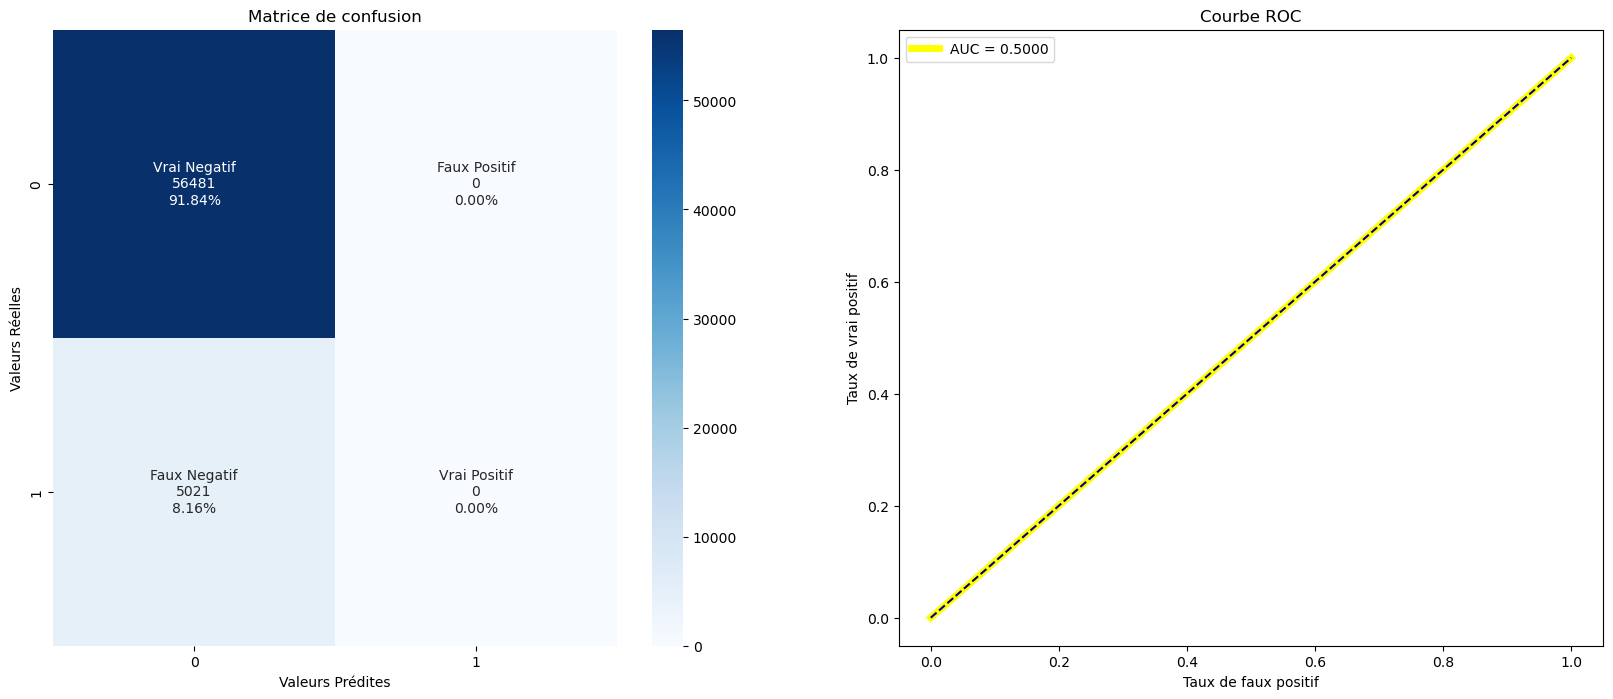

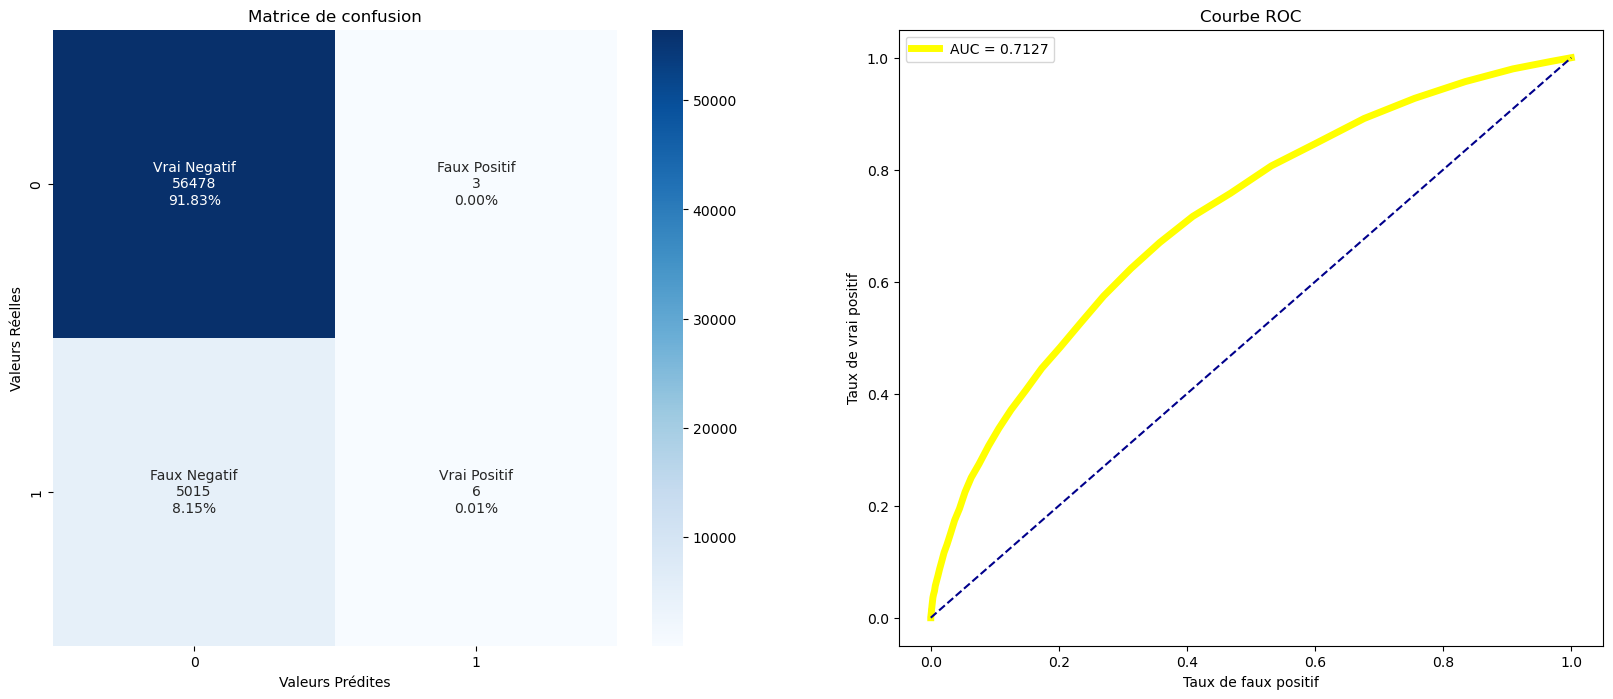

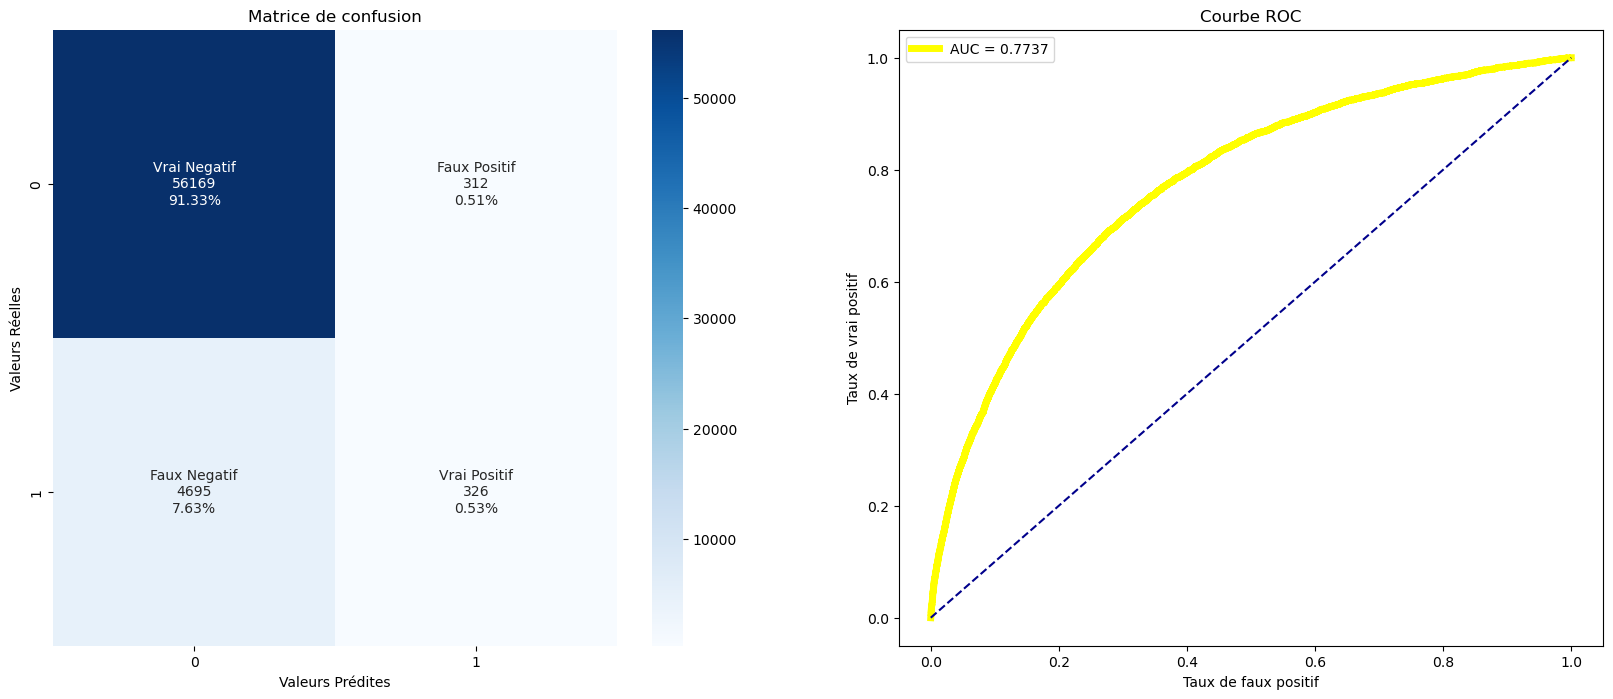

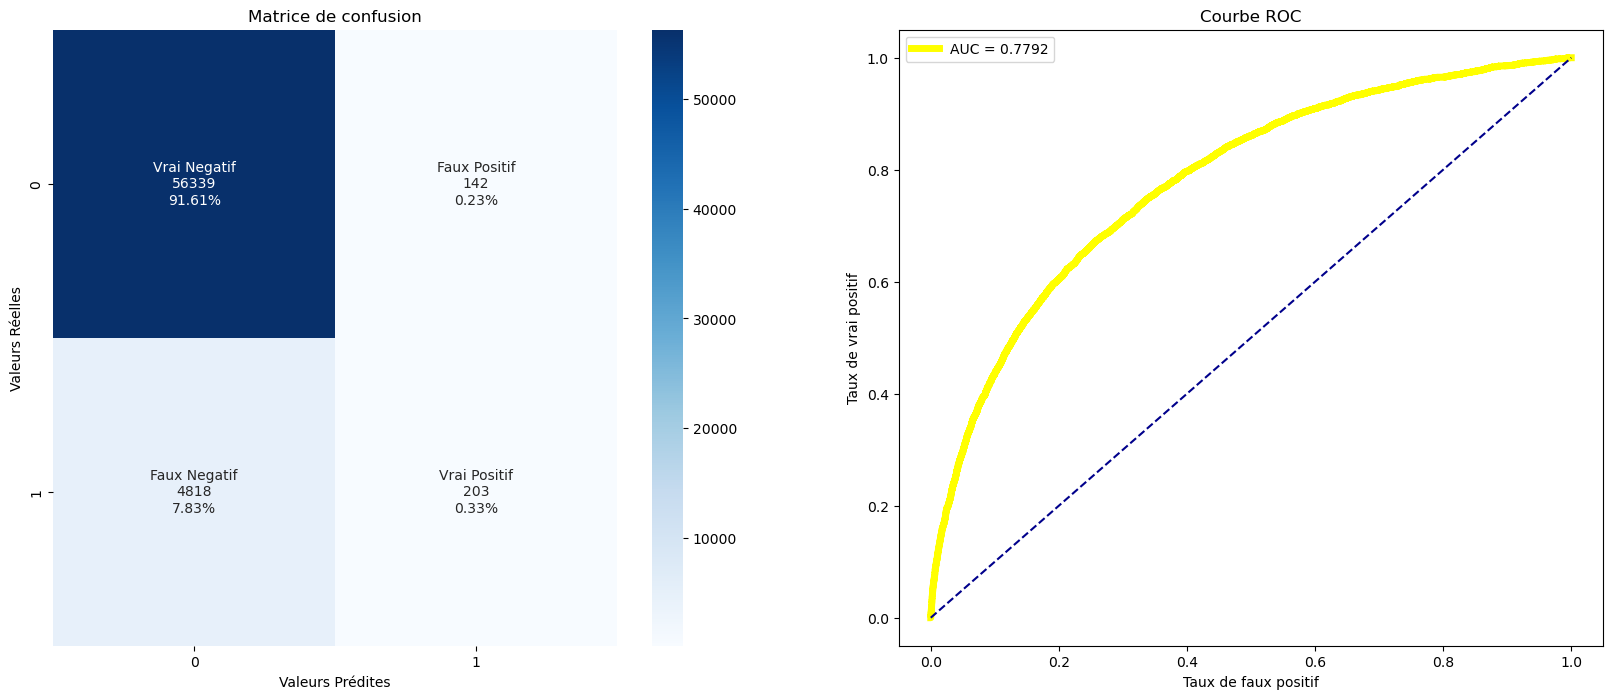

In [10]:
mlflow.set_experiment("Comparaison_modèles_sans_SMOTE")
mlflow.autolog()

sgd = calibration.CalibratedClassifierCV(SGDClassifier(loss = 'hinge'))
#knn = KNeighborsClassifier()
rfr = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

models = { 'SGDClassifier':sgd, 
          #'KNeighborsClassifier': knn, 
          'RandomForestClassifier': rfr, 
          'XGBClassifier': xgb, 
          'LGBMClassifier': lgbm
         }

#Sans OverSampling SMOTE
for m in models:
    with mlflow.start_run(run_name='Run_{}'.format(m)) as run:
        mlflow.set_tag("model", m)
        models[m].fit(Xtrain_i, ytrain_i)
        if models[m] in [sgd,rfr]:
            mlflow.sklearn.log_model(models[m], '{}'.format(m))
        elif models[m] == xgb:
            mlflow.xgboost.log_model(models[m], '{}'.format(m))
        else:
            mlflow.lightgbm.log_model(models[m], '{}'.format(m))
        cf_roc_plot(yvalid_i, models[m].predict(Xvalid_i), models[m].predict_proba(Xvalid_i), m)
        mlflow.end_run()

#### Oversamplig SMOTE

In [11]:
with timer("Oversampling SMOTE"):
    print("Label 1, Avant SMOTE: {} ".format(sum(ytrain==1)))
    print("Label 0, Avant SMOTE: {} ".format(sum(ytrain==0)))

    sm = SMOTE(random_state=2)
    Xtrain_smote, ytrain_smote = sm.fit_resample(Xtrain_i, ytrain_i)

    print("\nLabel 1, Après SMOTE: {}".format(sum(ytrain_smote==1)))
    print("Label 0, Après SMOTE: {}".format(sum(ytrain_smote==0)))

Label 1, Avant SMOTE: 19804 
Label 0, Avant SMOTE: 226201 


2023/06/14 09:04:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd616b75dbdcc4a0a94b3eef1518487b1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/14 09:04:39 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/06/14 09:04:39 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/06/14 09:04:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



Label 1, Après SMOTE: 226201
Label 0, Après SMOTE: 226201
Oversampling SMOTE - done in 21s


#### Comparaison avec Oversampling SMOTE

2023/06/14 09:04:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/14 09:04:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2023/06/14 09:04:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/14 09:04:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/06/14 09:04:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


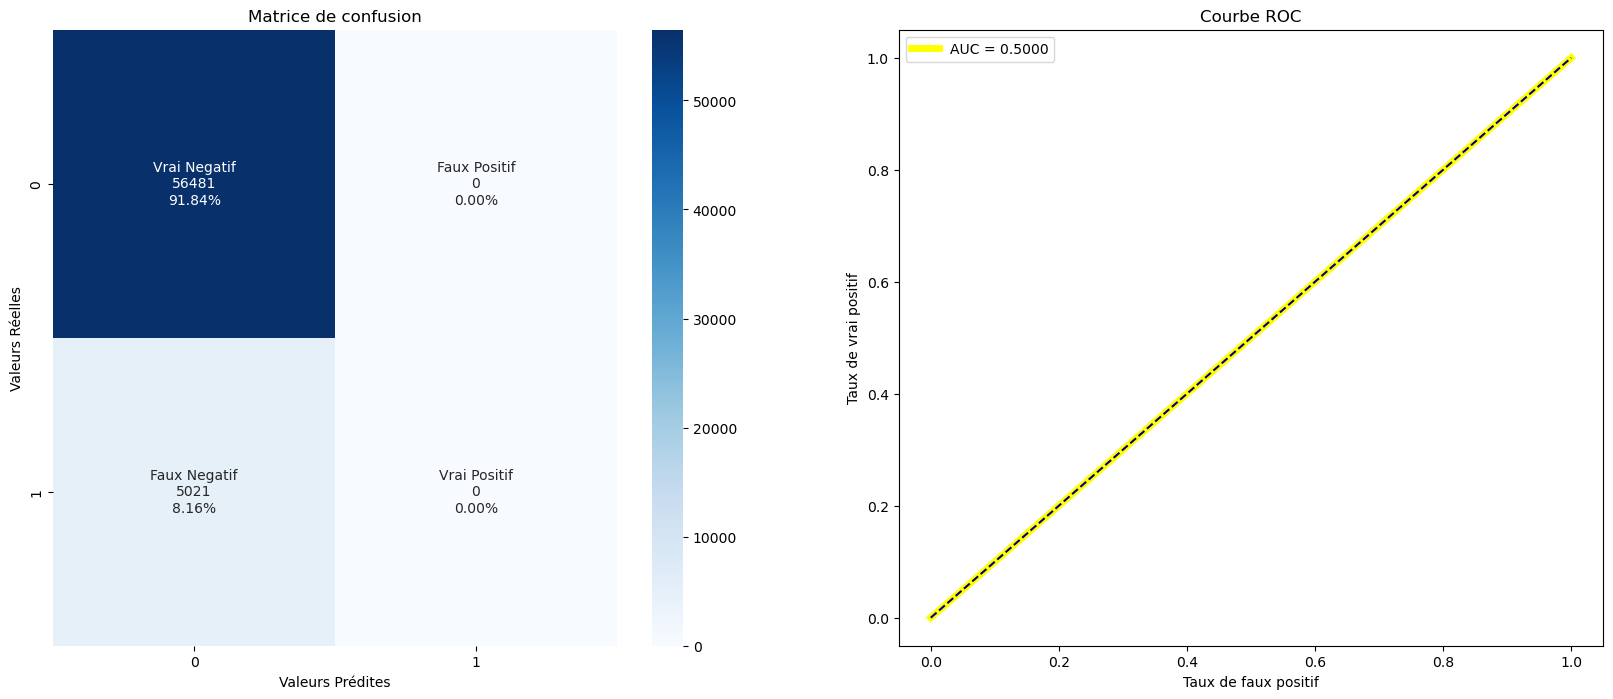

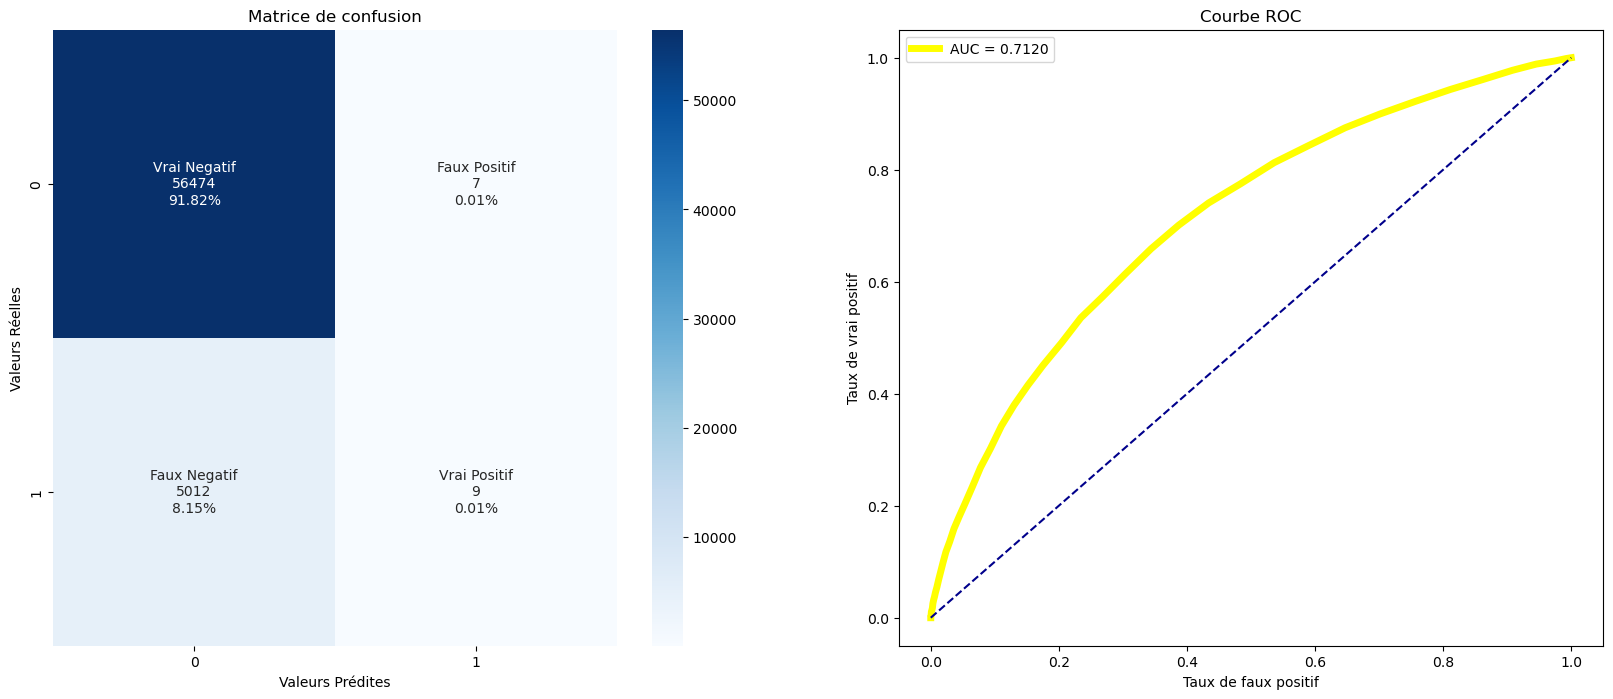

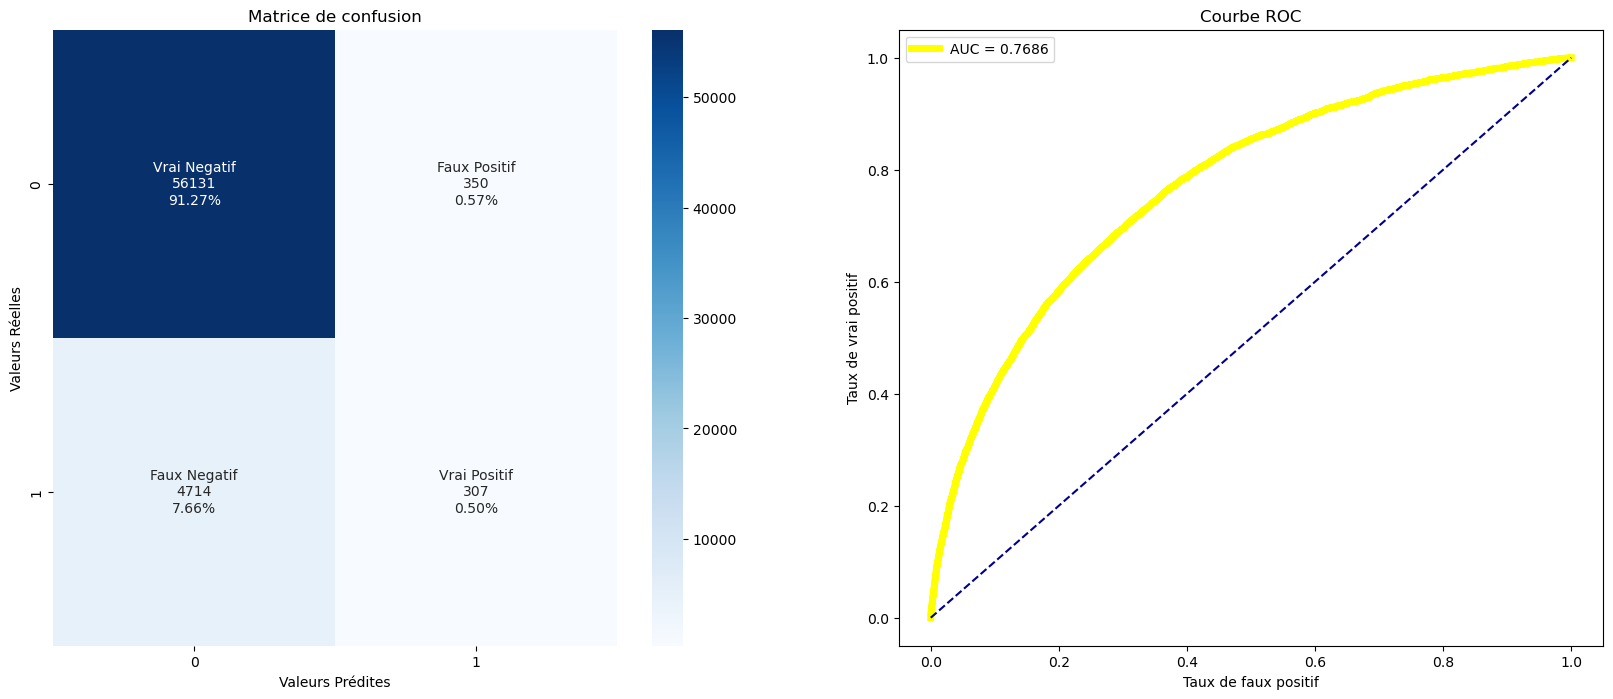

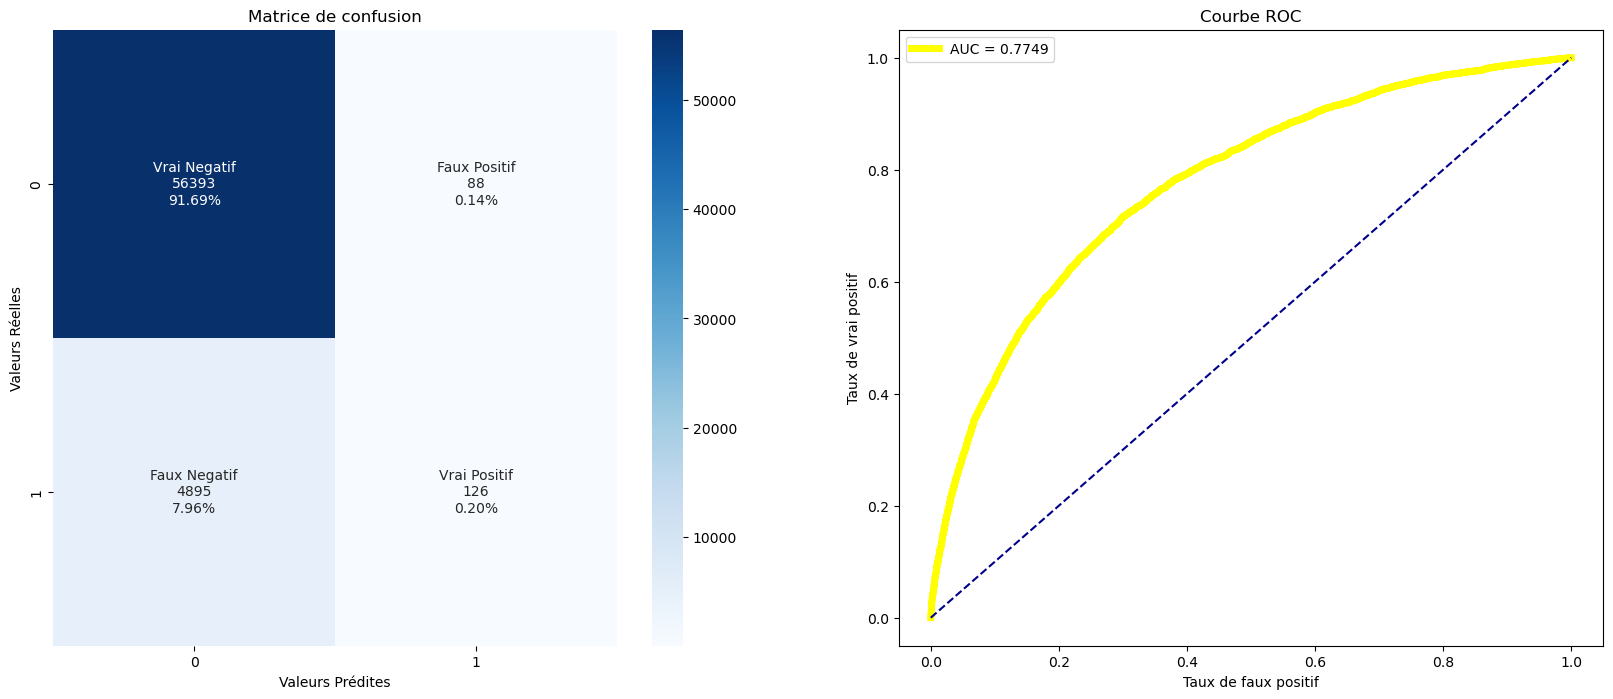

In [12]:
mlflow.set_experiment("Comparaison_modèles_avec_SMOTE")
mlflow.autolog()

for m in models:
    with mlflow.start_run(run_name='Run_{}_avec_SMOTE'.format(m)) as run:
        mlflow.set_tag("model", m)
        models[m].fit(Xtrain_smote, ytrain_smote)
        if models[m] in [sgd,rfr]:
            mlflow.sklearn.log_model(models[m], '{}_smote'.format(m))
        elif models[m] == xgb:
            mlflow.xgboost.log_model(models[m], '{}_smote'.format(m))
        else:
            mlflow.lightgbm.log_model(models[m], '{}_smote'.format(m))
        cf_roc_plot(yvalid_i, models[m].predict(Xvalid_i), models[m].predict_proba(Xvalid_i), '{}_avec_SMOTE'.format(m))
        mlflow.end_run()

#### Interface MLFlow

In [2]:
print('Interface Tracking UI http://localhost:5000')
!mlflow ui

Interface Tracking UI http://localhost:5000
^C


### Observations

LightGBM est choisi pour ces performances et surtout sa rapidité


## Optimisation du modèle

### Features selection

Utilisation de RFECV pour trouver le nombre de features optimal ainsi que les features pour optimiser le modèle

In [9]:
#Nombre de splits
cv = StratifiedKFold(n_splits = 5,  shuffle=True, random_state = 42)

mlflow.set_experiment("Features Selection")
mlflow.autolog()
with mlflow.start_run(run_name='Run_RFECV') as run:
    rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
                  step=5, 
                  cv=cv, 
                  scoring='roc_auc', 
                  verbose=2,
                  n_jobs=-1)
    rfecv.fit(Xtrain, ytrain)
    
    
    
    #Metriques
    mlflow.log_metric('Nombre de features optimal', rfecv.n_features_)
    step=5    
    
    #Plot
    plt.figure(figsize=(20, 8))
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
    plt.axvline( (rfecv.n_features_)/ 5, color= 'y')
    plt.xlabel('Nombre de features testées (x%d)' % step)
    plt.ylabel('Score de la cross-validation (roc_auc)')
    plt.savefig('Features_roc.png')
    plt.show()
    mlflow.log_artifact("Features_roc.png")
    #Plot number of features vs CV scores
    
    n = rfecv.n_features_
    for i in range(1, len(rfecv.cv_results_['mean_test_score']) + 1):
        mlflow.log_metric('Mean_test_Score_avec_{}_features'.format(n), rfecv.cv_results_['mean_test_score'][i-1])
        n = n+step

    mlflow.end_run()



2023/05/31 04:53:12 INFO mlflow.tracking.fluent: Experiment with name 'Features Selection' does not exist. Creating a new experiment.
2023/05/31 04:53:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/05/31 04:53:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/05/31 04:53:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2023/05/31 04:53:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/05/31 04:53:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


Fitting estimator with 795 features.
Fitting estimator with 790 features.
Fitting estimator with 785 features.
Fitting estimator with 780 features.
Fitting estimator with 775 features.
Fitting estimator with 770 features.
Fitting estimator with 765 features.
Fitting estimator with 760 features.
Fitting estimator with 755 features.
Fitting estimator with 750 features.
Fitting estimator with 745 features.
Fitting estimator with 740 features.
Fitting estimator with 735 features.
Fitting estimator with 730 features.
Fitting estimator with 725 features.
Fitting estimator with 720 features.
Fitting estimator with 715 features.
Fitting estimator with 710 features.
Fitting estimator with 705 features.
Fitting estimator with 700 features.
Fitting estimator with 695 features.
Fitting estimator with 690 features.
Fitting estimator with 685 features.
Fitting estimator with 680 features.
Fitting estimator with 675 features.
Fitting estimator with 670 features.
Fitting estimator with 665 features.
F

#### Sauvegarde des dataframmes

In [ ]:
#Liste des colonnes pour le modèle
col = rfecv.get_feature_names_out()
col2 = col.tolist()
for n in ['TARGET','SK_ID_CURR']:
    col2.append(n)

# DataFrame Train et Test
train_rfe = train_df[col2]
print('Shape de train set:', train_df.shape)
test_rfe = test_df[col2]
print('Shape de test set:', test_df.shape)

#Sauvegarde
train_rfe.to_csv('./Data/train_op.csv')
test_rfe.to_csv('./Data/test_op.csv')

# Metrique F-mesure

#### Test de la métrique métier 

Les Faux Positifs (FP) : les cas où la prédiction est positive, mais où la valeur réelle est négative.
Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé.

Les Faux Négatifs (FN) : les cas où la prédiction est négative, mais où la valeur réelle est positive.
Perte réelle si le crédit client accepté se transforme en défaut de paiement.

Pour les pénaliser on applique un coeficient négatif
On normalise le score pour qu'il soit compris entre 0 et 1

Le but étant de minimiser 

In [13]:
#Tests fonctionels avec des listes contenant 4 int: vp, vn, fp, fn
test_0 = [500, 300, 10, 1]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [500, 80, 0, 90]
test_6 = [90, 250, 180, 350]
test_7 = [200, 30, 300, 500]


tests = [test_0, test_1, test_2, test_3, test_4, test_5, test_6, test_7]

def f_mes(predictions_success: list) -> int:
    vp, vn, fp, fn = predictions_success
    
    #Liste des taux
    taux_vp = vp/(vp+fn)
    taux_vn = vn/(vn+fp)
    taux_fp = fp/(fp+vn)
    taux_fn = fn/(fn+vp)

    gain_tot = vp*taux_vp + vn*taux_vn - 2*fp*taux_fp - 20*fn*taux_fn
    gain_max = (fp+vp)*taux_vp + (vn+fn)*taux_vn
    perte_max = -(fp+vp)*(2*taux_fp) - (vn+fn)*(20* taux_fn)
    
    score = (gain_tot - perte_max) / (gain_max - perte_max)

    return score

In [14]:
for test in tests:
    print("  vp - vn - fp - fn\n", test)
    print("score:", f_mes(test))

  vp - vn - fp - fn
 [500, 300, 10, 1]
score: 0.9862364179186345
  vp - vn - fp - fn
 [500, 300, 30, 10]
score: 0.953030462001189
  vp - vn - fp - fn
 [400, 300, 70, 50]
score: 0.8549579588286459
  vp - vn - fp - fn
 [400, 300, 50, 70]
score: 0.8314967571311629
  vp - vn - fp - fn
 [350, 250, 80, 120]
score: 0.7027688308212827
  vp - vn - fp - fn
 [500, 80, 0, 90]
score: 0.6722535425872314
  vp - vn - fp - fn
 [90, 250, 180, 350]
score: 0.41436316010091323
  vp - vn - fp - fn
 [200, 30, 300, 500]
score: 0.09826122118883948


#### Chargement de données traitées

In [3]:
train_rfe = pd.read_csv('./Data/train_op.csv', index_col='Unnamed: 0')
train_rfe

CODE_GENDER  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          202500.0    406597.5      24700.5   
1                 1          270000.0   1293502.5      35698.5   
2                 0           67500.0    135000.0       6750.0   
3                 1          135000.0    312682.5      29686.5   
4                 0          121500.0    513000.0      21865.5   
...             ...               ...         ...          ...   
307506            0          157500.0    254700.0      27558.0   
307507            1           72000.0    269550.0      12001.5   
307508            1          153000.0    677664.0      29979.0   
307509            1          171000.0    370107.0      20205.0   
307510            1          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801       -9461   
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
307506         225000.0                    0.032561       -9327   
307507         225000.0                    0.025164      -20775   
307508         585000.0                    0.005002      -14966   
307509         319500.0                    0.005313      -11961   
307510         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  \
0              -637.0            -3648.0            -2120  ...   
1             -1188.0            -1186.0             -291  ...   
2              -225.0            -4260.0            -2531  ...   
3             -3039.0            -9833.0            -2437  ...   
4             -3038.0            -4311.0            -3458  ...   
...               ...                ...              ...  ...   
307506         -236.0            -8456.0            -1982  ...   
307507            NaN            -4388.0            -4090  ...   
307508        -7921.0            -6737.0            -5150  ...   
307509        -4786.0            -2562.0             -931  ...   
307510        -1262.0            -5128.0             -410  ...   

        CC_AMT_RECIVABLE_VAR  CC_CNT_DRAWINGS_ATM_CURRENT_MEAN  \
0                        NaN                               NaN   
1                        NaN                               NaN   
2                        NaN                               NaN   
3                        0.0                               NaN   
4                        NaN                               NaN   
...                      ...                               ...   
307506                   NaN                               NaN   
307507                   NaN                               NaN   
307508                   NaN                               NaN   
307509                   NaN                               NaN   
307510                   NaN                               NaN   

        CC_CNT_DRAWINGS_ATM_CURRENT_VAR  CC_CNT_DRAWINGS_CURRENT_MAX  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          0.0   
4                                   NaN                          NaN   
...                                 ...                          ...   
307506                              NaN                          NaN   
307507                              NaN                          NaN   
307508                              NaN                          NaN   
307509                              NaN                          NaN   
307510                          

In [4]:
feats = [f for f in train_rfe.columns if f not in ['TARGET','SK_ID_CURR']]
Xtrain_rfe, Xvalid_rfe, ytrain_rfe, yvalid_rfe = train_test_split(train_rfe[feats], train_rfe['TARGET'],test_size=0.2, 
                                                  shuffle= True, random_state = 40)

In [17]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from imblearn import pipeline

def my_score(ytrue, ypred):
    
    vn, fp, fn, vp = metrics.confusion_matrix(ytrue, ypred).ravel()
  
    #Liste des taux
    taux_vp = vp/(vp+fn)
    taux_vn = vn/(vn+fp)
    taux_fp = fp/(fp+vn)
    taux_fn = fn/(fn+vp)
    

    gain_tot = vp*taux_vp + vn*taux_vn - 2*fp*taux_fp - 20*fn*taux_fn
    gain_max = (fp+vp)*taux_vp + (vn+fn)*taux_vn
    perte_max = -(fp+vp)*(2*taux_fp) - (vn+fn)*(20* taux_fn)
    
    fscore = (gain_tot - perte_max) / (gain_max - perte_max)
    
    return fscore

def objective(params, eval_metric='my_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
    cv = StratifiedKFold(n_splits = 5,  shuffle=True, random_state = 42)
    
    pipeline_mod=pipeline.Pipeline(steps = [['imputer', impute.SimpleImputer(missing_values=np.nan, strategy='mean')],
                                            ['smote', SMOTE(random_state=41)],
                                            ['classifier', LGBMClassifier(**params)]])
    
    y_pred = cross_val_predict(pipeline_mod, Xtrain_rfe, ytrain_rfe, method='predict', cv=cv)
    score = my_score(ytrain_rfe, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [18]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

2023/06/14 10:47:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/14 10:47:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2023/06/14 10:47:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/14 10:47:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/06/14 10:47:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

2023/06/14 10:47:07 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 10:47:07 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 10:47:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 10:47:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'n_jobs\' was already logged with value=\'None\' for run ID=

  3%|█▌                                           | 1/30 [03:14<1:33:54, 194.30s/trial, best loss: 0.07876055088404377]

2023/06/14 10:50:21 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 10:50:21 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 10:50:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 10:50:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

  7%|███                                           | 2/30 [05:23<1:12:50, 156.11s/trial, best loss: 0.0787330308207338]

2023/06/14 10:52:30 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 10:52:30 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 10:52:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 10:52:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 10%|████▌                                         | 3/30 [07:53<1:08:54, 153.15s/trial, best loss: 0.0787330308207338]

2023/06/14 10:55:00 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 10:55:00 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 10:55:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 10:55:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 13%|██████                                       | 4/30 [11:01<1:12:20, 166.94s/trial, best loss: 0.07720867790509534]

2023/06/14 10:58:08 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 10:58:08 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 10:58:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 10:58:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 17%|███████▌                                     | 5/30 [12:48<1:00:37, 145.51s/trial, best loss: 0.07718792569875088]

2023/06/14 10:59:56 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 10:59:56 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 10:59:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:00:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 20%|█████████                                    | 6/30 [15:30<1:00:24, 151.03s/trial, best loss: 0.07718792569875088]

2023/06/14 11:02:37 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:02:37 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:02:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:02:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 23%|██████████▉                                    | 7/30 [17:13<51:52, 135.33s/trial, best loss: 0.07718792569875088]

2023/06/14 11:04:20 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:04:20 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:04:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:04:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 27%|████████████▌                                  | 8/30 [20:10<54:27, 148.52s/trial, best loss: 0.07718792569875088]

2023/06/14 11:07:17 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:07:17 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:07:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:07:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 30%|██████████████                                 | 9/30 [21:40<45:33, 130.15s/trial, best loss: 0.07718792569875088]

2023/06/14 11:08:47 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:08:47 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:08:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:09:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 33%|███████████████▎                              | 10/30 [24:29<47:23, 142.17s/trial, best loss: 0.07718792569875088]

2023/06/14 11:11:36 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:11:36 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:11:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:11:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 37%|████████████████▊                             | 11/30 [26:47<44:39, 141.05s/trial, best loss: 0.07718792569875088]

2023/06/14 11:13:54 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:13:54 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:13:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:14:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 40%|██████████████████▍                           | 12/30 [28:41<39:46, 132.61s/trial, best loss: 0.07676191066812998]

2023/06/14 11:15:48 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:15:48 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:15:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:16:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 43%|███████████████████▉                          | 13/30 [31:02<38:21, 135.35s/trial, best loss: 0.07676191066812998]

2023/06/14 11:18:09 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:18:09 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:18:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:18:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 47%|█████████████████████▍                        | 14/30 [32:36<32:45, 122.85s/trial, best loss: 0.07676191066812998]

2023/06/14 11:19:43 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:19:43 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:19:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:19:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 50%|███████████████████████                       | 15/30 [34:20<29:16, 117.07s/trial, best loss: 0.07676191066812998]

2023/06/14 11:21:27 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:21:27 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:21:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:21:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 53%|████████████████████████▌                     | 16/30 [36:01<26:12, 112.29s/trial, best loss: 0.07676191066812998]

2023/06/14 11:23:08 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:23:08 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:23:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:23:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 57%|██████████████████████████                    | 17/30 [39:21<30:03, 138.72s/trial, best loss: 0.07676191066812998]

2023/06/14 11:26:29 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:26:29 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:26:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:27:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 60%|███████████████████████████▌                  | 18/30 [42:41<31:23, 156.92s/trial, best loss: 0.07676191066812998]

2023/06/14 11:29:49 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:29:49 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:29:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:30:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 63%|█████████████████████████████▏                | 19/30 [45:49<30:29, 166.30s/trial, best loss: 0.07676191066812998]

2023/06/14 11:32:56 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:32:56 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:32:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:33:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 67%|██████████████████████████████▋               | 20/30 [48:47<28:20, 170.02s/trial, best loss: 0.07676191066812998]

2023/06/14 11:35:55 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:35:55 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:35:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 70%|████████████████████████████████▏             | 21/30 [50:27<22:18, 148.76s/trial, best loss: 0.07376166528345363]

2023/06/14 11:37:34 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:37:34 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:37:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:37:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 73%|█████████████████████████████████▋            | 22/30 [52:08<17:57, 134.64s/trial, best loss: 0.07376166528345363]

2023/06/14 11:39:16 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:39:16 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:39:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:39:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 77%|███████████████████████████████████▎          | 23/30 [54:02<14:59, 128.44s/trial, best loss: 0.07376166528345363]

2023/06/14 11:41:10 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:41:10 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:41:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 80%|████████████████████████████████████▊         | 24/30 [55:42<11:58, 119.73s/trial, best loss: 0.07376166528345363]

2023/06/14 11:42:49 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:42:49 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:42:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 83%|███████████████████████████████████████▏       | 25/30 [57:08<09:08, 109.60s/trial, best loss: 0.0727833542419355]

2023/06/14 11:44:15 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:44:15 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:44:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:44:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 87%|████████████████████████████████████████▋      | 26/30 [58:34<06:50, 102.65s/trial, best loss: 0.0727833542419355]

2023/06/14 11:45:41 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:45:41 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:45:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:45:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 90%|██████████████████████████████████████████▎    | 27/30 [59:57<04:50, 96.82s/trial, best loss: 0.07275923781345084]

2023/06/14 11:47:05 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:47:05 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:47:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:47:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 93%|██████████████████████████████████████████   | 28/30 [1:01:36<03:14, 97.43s/trial, best loss: 0.07275923781345084]

2023/06/14 11:48:44 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:48:44 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:48:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:48:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

 97%|██████████████████████████████████████████▌ | 29/30 [1:03:22<01:40, 100.01s/trial, best loss: 0.07275923781345084]

2023/06/14 11:50:30 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.

2023/06/14 11:50:30 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature

2023/06/14 11:50:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2023/06/14 11:51:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 804024f779e84839983521e4c2c431ff. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.639828

100%|████████████████████████████████████████████| 30/30 [1:07:08<00:00, 134.28s/trial, best loss: 0.07275923781345084]
best params: {'n_estimators': 100, 'learning_rate': 0.01945696576627986, 'max_depth': 3, 'subsample': 0.941066248492478, 'colsample_bytree': 0.8804405602864773, 'reg_lambda': 5.574164569138075}

best loss score 0.07275923781345084


2023/06/14 11:54:15 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/06/14 11:54:15 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/06/14 11:54:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/06/14 11:54:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 312dc139253841de8e80b13de65ce8dd. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'n_jobs\' was already logged with value=\'None\' for run ID=\'3

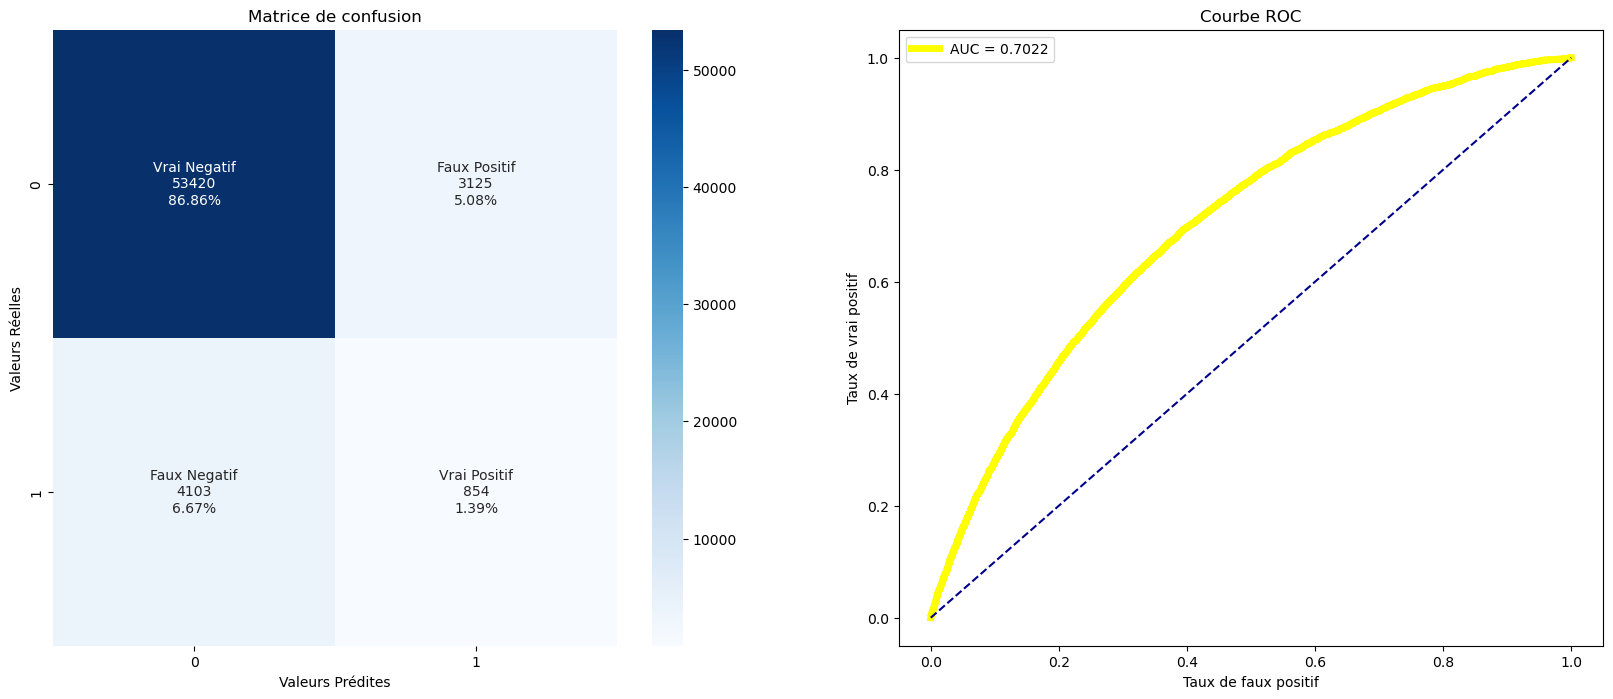

In [19]:
mlflow.set_experiment("Optimisation")
mlflow.autolog()
with mlflow.start_run(run_name='Hyperopt_LightGBM') as run:
    b_trials = Trials()
    best = fmin(fn=objective, 
                space=space, 
                max_evals=30, 
                rstate=np.random.default_rng(seed=42), 
                algo=tpe.suggest, 
                trials=b_trials)
    
    best_score = b_trials.results[np.argmin([r['loss'] for r in b_trials.results])]
    
    print("best params:", best_score['params'])
    print("\nbest loss score", best_score['loss'])
    mlflow.log_param('Best params', best_score['params'])
    mlflow.log_metric(" Best loss score" , best_score['loss']) 
    mlflow.end_run()

with mlflow.start_run(run_name='LightGBM_optimise_sans_seuil') as run:    
    lgbm = pipeline.Pipeline(steps = [['imputer', impute.SimpleImputer(missing_values=np.nan, strategy='mean')],
                                      ['smote', SMOTE(random_state=41)],
                                      ['classifier', LGBMClassifier(**best_score['params'])]])

    lgbm.fit(Xtrain_rfe, ytrain_rfe)
    cf_roc_plot(yvalid_rfe, lgbm.predict(Xvalid_rfe), lgbm.predict_proba(Xvalid_rfe), 'lightGBM_optimise')
    mlflow.lightgbm.log_model(lgbm['classifier'],'model_sans_seuil')
    
    mlflow.end_run()
    
    

In [20]:
# Sauvegarde du modele
joblib.dump(lgbm, 'model_sans_seuil.sav')

['model_sans_seuil.sav']

Score métrique métier maximal : 0.9320517000110344
Seuil maximal : 0.44


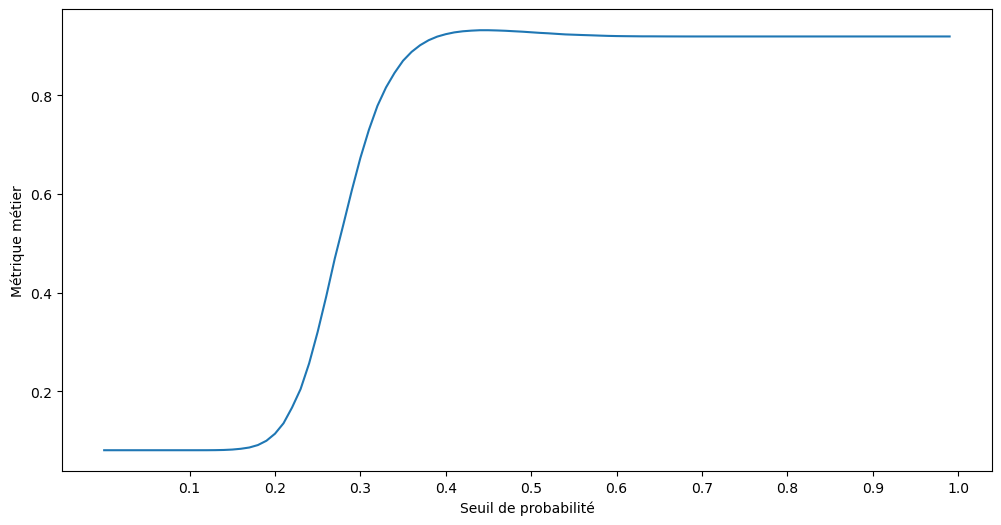

In [21]:
seuils = np.arange(0, 1, 0.01)
sav_gains = []

for seuil in seuils:

    # Score du modèle : n = 0 ou 1
    y_proba = lgbm.predict_proba(Xvalid_rfe)[:, 1]

    # Score > seuil de solvabilité : retourne 1 sinon 0
    y_pred = (y_proba > seuil)
    y_pred = np.multiply(y_pred, 1)

    # Sauvegarde du score de la métrique métier
    sav_gains.append(my_score(yvalid_rfe, y_pred))

df_score = pd.DataFrame({'Seuils' : seuils,
                         'Gains' : sav_gains})

# Score métrique métier maximal
gain_max = df_score['Gains'].max()
print(f'Score métrique métier maximal : {gain_max}')
# Seuil optimal pour notre métrique
seuil_max = df_score.loc[df_score['Gains'].argmax(), 'Seuils']
print(f'Seuil maximal : {seuil_max}')

# Affichage du gain en fonction du seuil de solvabilité
plt.figure(figsize=(12, 6))
plt.plot(seuils, sav_gains)
plt.xlabel('Seuil de probabilité')
plt.ylabel('Métrique métier')
plt.xticks(np.linspace(0.1, 1, 10))
plt.show()


In [22]:
seuils = np.arange(seuil_max - 0.01 , seuil_max + 0.01, 0.001)
sav_gains = []

for seuil in seuils:

    # Score du modèle : n = 0 ou 1
    y_proba = lgbm.predict_proba(Xvalid_rfe)[:, 1]

    # Score > seuil de solvabilité : retourne 1 sinon 0
    y_pred = (y_proba > seuil)
    y_pred = np.multiply(y_pred, 1)

    # Sauvegarde du score de la métrique métier
    sav_gains.append(my_score(yvalid_rfe, y_pred))

df_score = pd.DataFrame({'Seuils' : seuils,
                         'Gains' : sav_gains})

# Score métrique métier maximal
gain_max = df_score['Gains'].max()
print(f'Score métrique métier maximal : {gain_max}')
# Seuil optimal pour notre métrique
seuil_max = df_score.loc[df_score['Gains'].argmax(), 'Seuils']
print(f'Seuil maximal : {seuil_max}')

Score métrique métier maximal : 0.932143926262416
Seuil maximal : 0.442


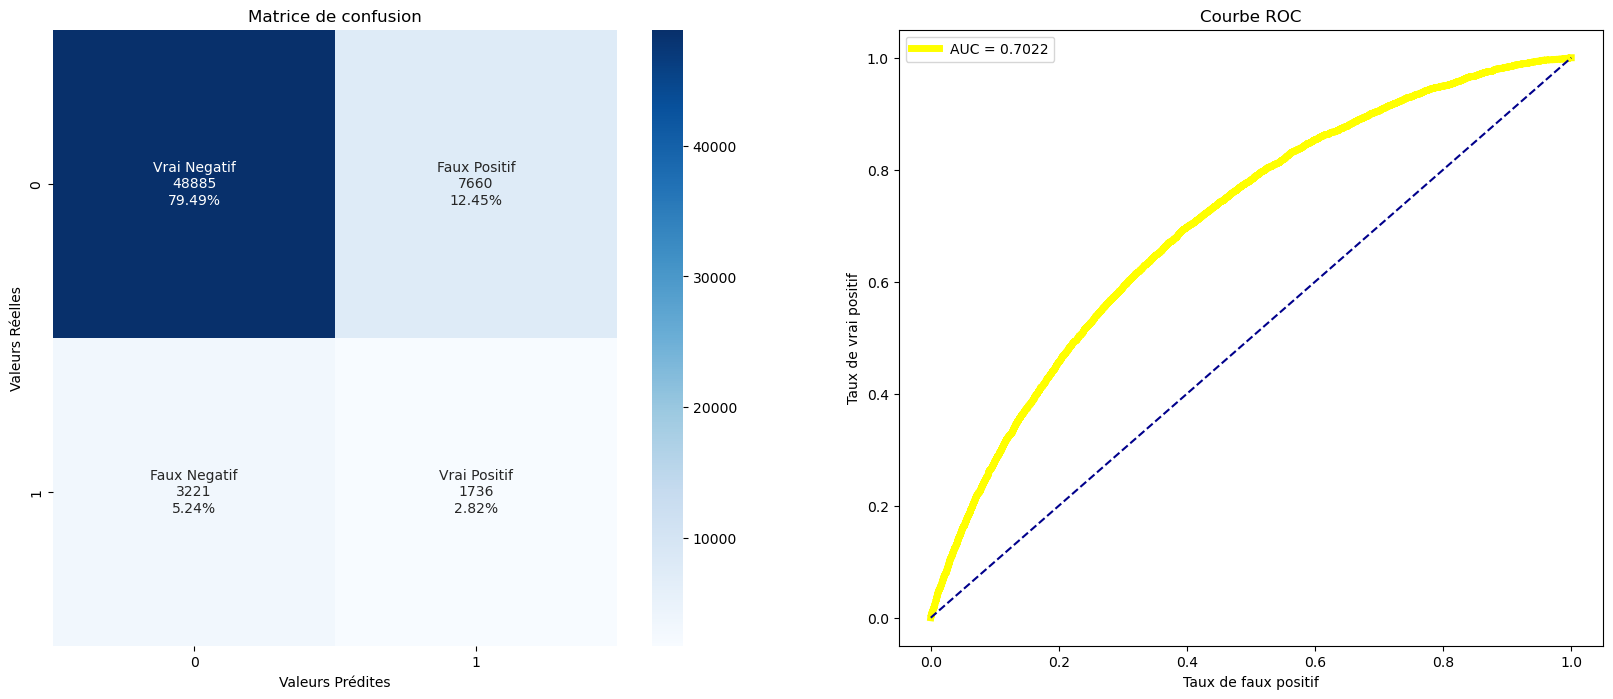

In [23]:

# Score > seuil de probabilité : retourne 1 sinon 0
ypred = (y_proba > seuil_max)
ypred = np.multiply(ypred, 1)

with mlflow.start_run(run_name='LightGBM_optimise_avec_seuil') as run:

    cf_roc_plot(yvalid_rfe, ypred, lgbm.predict_proba(Xvalid_rfe),'lightGBM_avec_seuil')
    
    mlflow.end_run()

### Features Importance

In [24]:
def plot_features_importance(features_importance, nom_variables,
                             figsize=(6, 5) ):
    
    df_feat_imp = pd.DataFrame({'feature': nom_variables,
                                'importance': features_importance})
    df_feat_imp_tri = df_feat_imp.sort_values(by='importance')
    
    
    # BarGraph de visalisation
    plt.figure(figsize=figsize)
    plt.barh(df_feat_imp_tri['feature'], df_feat_imp_tri['importance'])
    plt.yticks(fontsize=8)
    plt.xlabel('Feature Importances (%)')
    plt.ylabel('Variables', fontsize=10)
    plt.title('Comparison des Features Importances', fontsize=12)
    plt.savefig("./Visualisations/Comparison des Features Importances.png", bbox_inches='tight')
    plt.show()

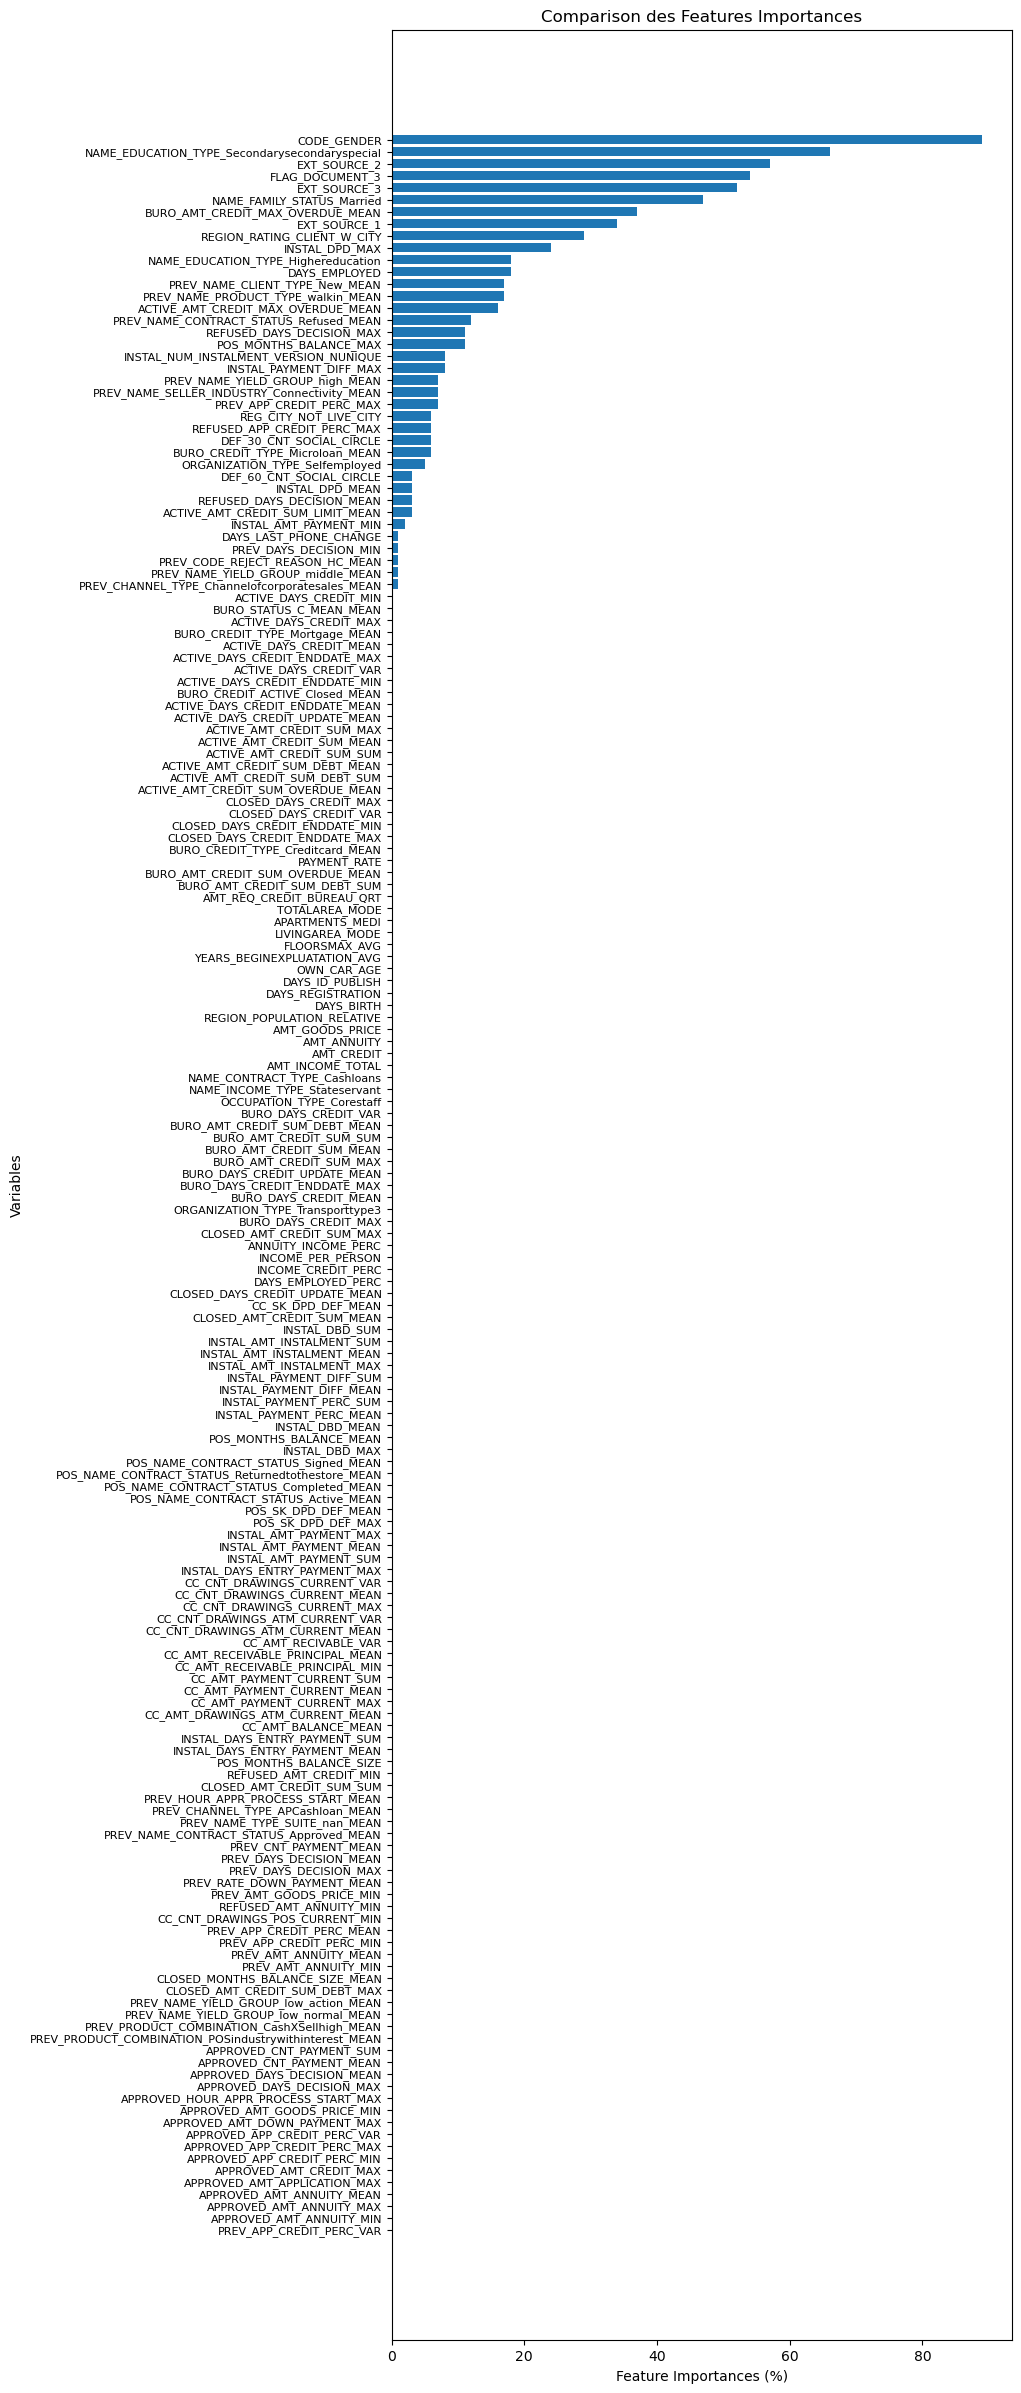

In [25]:
feature_importance_values = lgbm['classifier'].feature_importances_

feature_names = list(Xtrain_rfe.columns)
plot_features_importance(feature_importance_values,feature_names, (8, 30))

2023/06/14 12:28:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/14 12:28:57 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2023/06/14 12:28:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/14 12:28:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/14 12:28:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
100%|===================| 61483/61502 [01:19<00:00]        

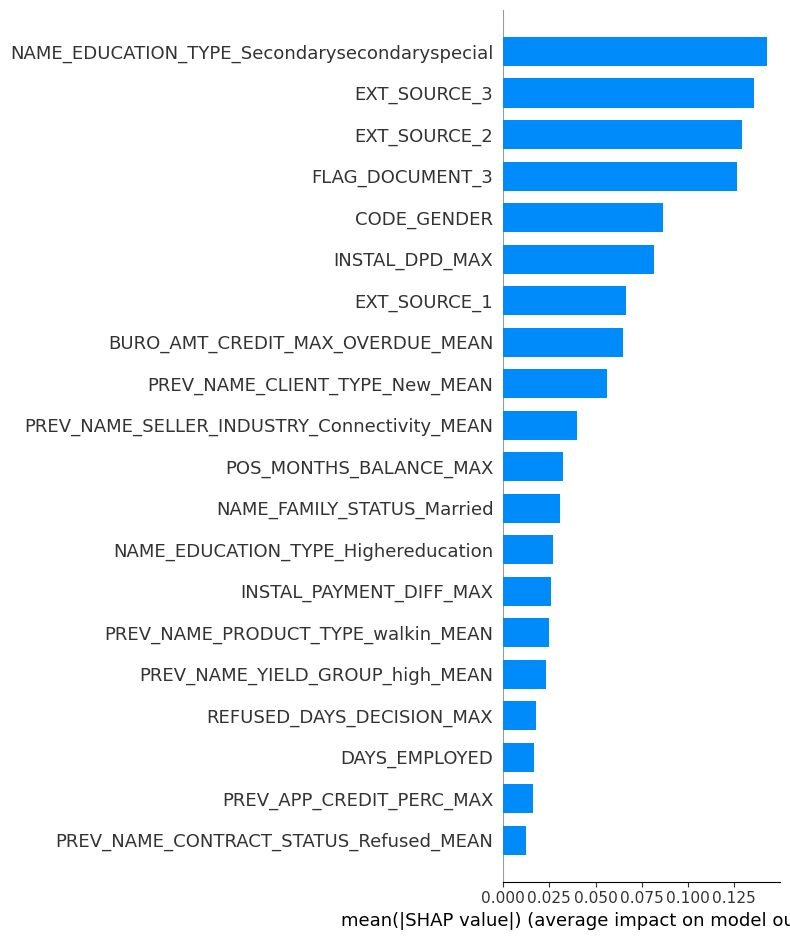

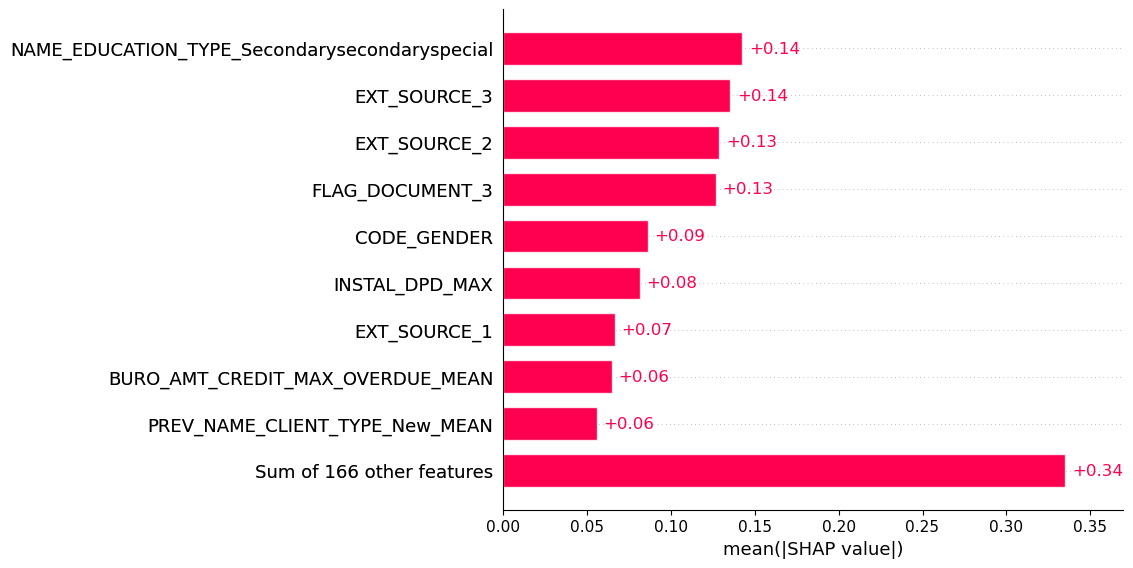

In [6]:
mlflow.set_experiment("Features_Importance_SHAP")
mlflow.autolog()
with mlflow.start_run(run_name='Shap_global') as run:
    #Explainer
    explainer = shap.Explainer(lgbm['classifier'], Xtrain_rfe)
    shap_values = explainer(Xvalid_rfe)
    #Visualisation
    shap.summary_plot(shap_values, Xvalid_rfe.columns.tolist(), plot_type="bar",show=False)
    plt.savefig("./Visualisations/Features_importance_globales.png")
    plt.show()
    mlflow.log_artifact("./Visualisations/Features_importance_globales.png")
    shap.plots.bar(shap_values,show=False)
    plt.savefig("./Visualisations/Features_importance_globales_2.png", bbox_inches='tight')
    plt.show()
    mlflow.log_artifact("./Visualisations/Features_importance_globales_2.png")
    mlflow.end_run()

### Local

2023/06/14 12:30:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/14 12:30:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2023/06/14 12:30:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/14 12:30:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/14 12:30:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


Cas non défaillant

Proba: [0.67632501 0.32367499]
Prediction: 0.0


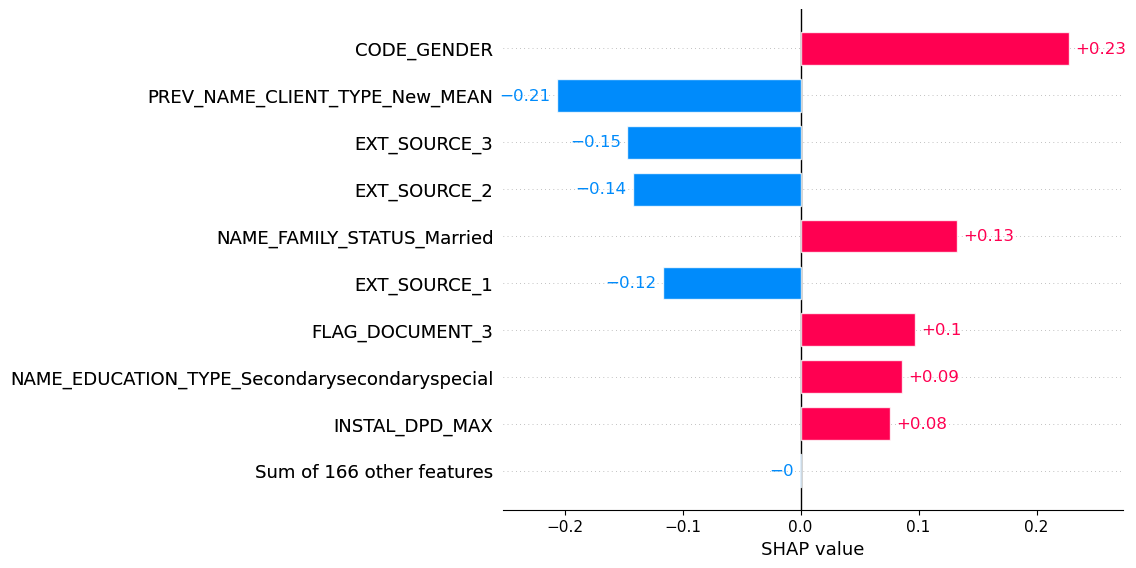


Cas défaillant

Proba: [0.4951606 0.5048394]
Prediction: 1.0


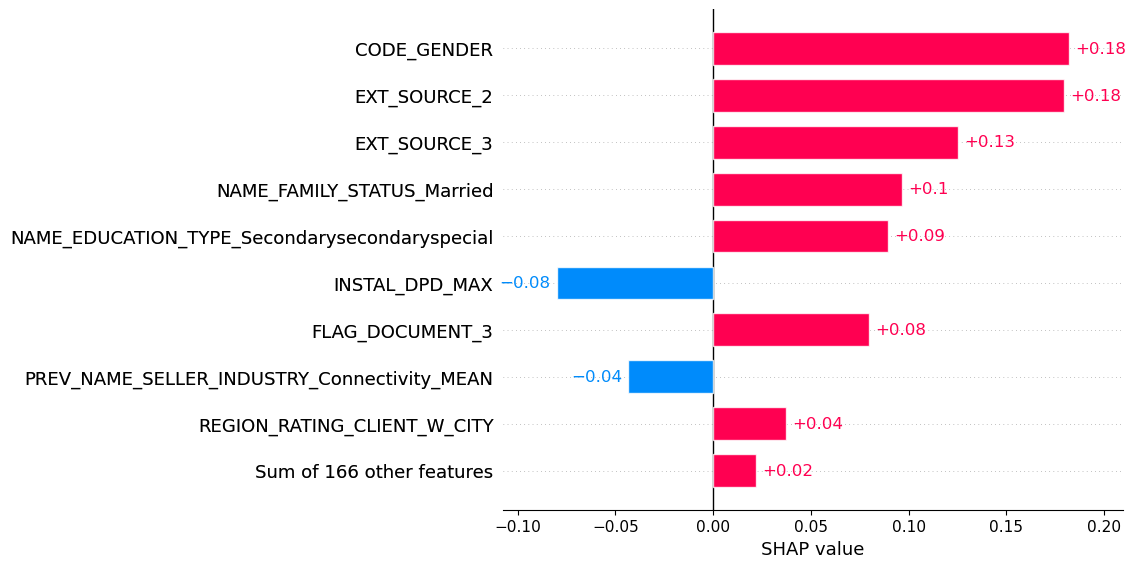

In [7]:
mlflow.set_experiment("Features_Importance_SHAP")
mlflow.autolog()
with mlflow.start_run(run_name='Shap_local') as run:
    #Cas non défaillant
    print('Cas non défaillant\n')
    print('Proba:',lgbm.predict_proba(Xvalid_rfe)[11])
    print('Prediction:',lgbm.predict(Xvalid_rfe)[11])
    shap.plots.bar(shap_values[11],show=False)
    plt.savefig("./Visualisations/Shap_local_cas_non_defaillant.png", bbox_inches='tight')
    plt.show()
    mlflow.log_artifact("./Visualisations/Shap_local_cas_non_defaillant.png")
    #Cas défaillant
    print('\nCas défaillant\n')
    print('Proba:',lgbm.predict_proba(Xvalid_rfe)[23])
    print('Prediction:',lgbm.predict(Xvalid_rfe)[23])
    shap.plots.bar(shap_values[23],show=False)
    plt.savefig("./Visualisations/Shap_local_cas_defaillant.png", bbox_inches='tight')
    plt.show()
    mlflow.log_artifact("./Visualisations/Shap_local_cas_defaillant.png")
    mlflow.end_run()

# DATA DRIFT

Le Data Drift fait référence aux changements dans les caractéristiques statistiques des données au fil du temps. Il peut affecter la performance des modèles d'apprentissage automatique et nécessite une surveillance continue et des mesures d'adaptation pour maintenir la précision des prédictions.

In [41]:
import evidently
evidently.__version__

'0.3.2'

In [42]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, ClassificationPreset

In [43]:
df_train = pd.read_csv('./Data/train_op.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('./Data/test_op.csv', index_col='Unnamed: 0')

In [44]:
df_train.shape

(307507, 177)

In [45]:
df_test.shape

(48744, 177)

In [47]:
data_drift_report = Report(metrics=[
   DataDriftPreset(),
])

data_drift_report.run(reference_data=df_train.drop(['TARGET','SK_ID_CURR'], axis=1),
                      current_data=df_test.drop(['TARGET','SK_ID_CURR'], axis=1), 
                      column_mapping=None)
data_drift_report

### Sauvegarde du tableau de bord sous format html

In [48]:
data_drift_report.save_html('data_drift_report.html')
data_drift_report.json()

'{"version": "0.3.2", "timestamp": "2023-06-14 03:59:24.261335", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 175, "number_of_drifted_columns": 15, "share_of_drifted_columns": 0.08571428571428572, "dataset_drift": false}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 175, "number_of_drifted_columns": 15, "share_of_drifted_columns": 0.08571428571428572, "dataset_drift": false, "drift_by_columns": {"ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN": {"column_name": "ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.06273809423089828, "drift_detected": false, "current": {"small_distribution": {"x": [0.0, 75727.35, 151454.7, 227182.05000000002, 302909.4, 378636.75, 454364.10000000003, 530091.4500000001, 605818.8, 681546.15, 757273.5], "y": [1.3172566911501067e-05, 2.8030051354417686e-08, 3.8930626881135674e-09, 0.0, 0.0, 0.0, 0.0, 0.0,